In [1]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import col, when, lit, udf, greatest, mean as _mean, stddev as _stddev, max as spark_max, min as spark_min, expm1, row_number
import numpy as np
import pandas as pd
from pyspark.sql.types import StringType
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.window import Window
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.ml.regression import GBTRegressor


In [ ]:
spark = SparkSession.builder \
    .appName("OnlineeModelCVFinal") \
    .config("spark.hadoop.fs.defaultFS", "hdfs://namenode:9000") \
    .getOrCreate()

parquet_path = "hdfs://namenode:9000/user/hadoop/dane_przetworzone/online_training_dataset_with_offline_preds_final.parquet"
df = spark.read.parquet(parquet_path)

df.show(5)

pdf = df.toPandas()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/01 13:27:25 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/06/01 13:27:26 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/06/01 13:27:26 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
25/06/01 13:27:32 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
                                                                                

+-------------------+-----------+--------+---------+----+--------+--------+-----------+----------+--------+----+----+---+----+---+----+-----------+-----+----+--------+--------+--------+--------+-------+-------+------+------+-------+-------+-------------------------------+-------------------------------+-------------------------------+-------------------------------+-------------------------------+-------------------------------+-------------------------------+-------------------------------+-------------------------------+-------------------------------+-------------------------------+-------------------------------+-------------------------------+-------------------------------+-------------------------------+-------------------------------+-------------------------------+-------------------------------+-------------------------------+-------------------------------+-------------------------------+-------------------------------+-------------------------------+------------------------

In [3]:
pollutants = ['pm10', 'pm25', 'no2', 'so2', 'o3']
percentiles_98 = {}

for pol in pollutants:
    q = df.approxQuantile(pol, [0.98], 0.00)
    percentiles_98[pol] = q[0]
    print(f"{pol}: 98. percentyl = {q[0]:.2f}")

pm10: 98. percentyl = 60.80
pm25: 98. percentyl = 25.90
no2: 98. percentyl = 77.10
so2: 98. percentyl = 4.90
o3: 98. percentyl = 111.80


In [ ]:
all_cols = df.columns
cols_to_check = []

for pol in pollutants:
    for c in all_cols:
        if c == pol or c.startswith(pol + '_t'):
            cols_to_check.append((c, pol))

In [ ]:
from functools import reduce

filter_condition = reduce(
    lambda acc, pair: acc & (col(pair[0]) <= percentiles_98[pair[1]]),
    cols_to_check,
    col(cols_to_check[0][0]) <= percentiles_98[cols_to_check[0][1]]
)

filtered_df = df.filter(filter_condition)
print(f"Liczba rekordów po filtracji: {filtered_df.count()}")

Liczba rekordów po filtracji: 184


In [ ]:
pollutants = ["pm10", "pm25", "no2", "so2", "o3"]

feature_cols = [
    "temperature", "humidity", "dew_point", "rain",
    "pressure", "cloud_cover", "wind_speed", "wind_dir",
    "hour", "day_of_week",
    "pm10", "pm25", "no2", "o3", "so2",
    "pm10_t-1", "pm25_t-1", "no2_t-1", "o3_t-1", "so2_t-1"
]


traffic_cols = [c for c in filtered_df.columns if c.startswith("trafficJamRatio")]

feature_cols += traffic_cols

ratios = {}
for c in traffic_cols:
    ratio_ones = filtered_df.select(_mean(when(col(c) == 1, 1).otherwise(0))).collect()[0][0]
    ratios[c] = ratio_ones

cols_to_remove = [col_name for col_name, ratio in ratios.items() if ratio > 0.9]

print(f"Usuwam z feature_cols kolumny z >90% wartości równych 1:\n{cols_to_remove}")

feature_cols_less_traffic = [c for c in feature_cols if c not in cols_to_remove]

print(f"Liczba cech po usunięciu: {len(feature_cols_less_traffic)}")


Usuwam z feature_cols kolumny z >90% wartości równych 1:
['trafficJamRatio_52-1882_20-9135', 'trafficJamRatio_52-1934_20-9244', 'trafficJamRatio_52-2014_20-9366', 'trafficJamRatio_52-2037_20-9065', 'trafficJamRatio_52-2051_20-9105', 'trafficJamRatio_52-2072_20-9073', 'trafficJamRatio_52-2077_20-9040', 'trafficJamRatio_52-2081_20-9073', 'trafficJamRatio_52-2089_20-9057', 'trafficJamRatio_52-2089_20-9071', 'trafficJamRatio_52-2096_20-9078']
Liczba cech po usunięciu: 42


In [ ]:
def timeseries_cv_rf(
    df_to_cv,
    datetime_col,
    feature_cols,
    target_col,
    param_grid,
    folds=3,
    seed=42,
    is_log=False,
    model_save_path=None
):
    """
    Time series cross-validation dla RandomForest na danych Spark.

    df_to_cv - Spark DataFrame posortowany po datetime_col
    datetime_col - kolumna datetime, do sortowania
    feature_cols - lista kolumn cech
    target_col - nazwa kolumny celu (label)
    param_grid - dict z hiperparametrami, np. {"numTrees": [50,100], "maxDepth": [5,10]}
    folds - liczba foldów CV
    seed - seed do losowości (jeśli potrzebne)
    is_log - czy target jest w log1p (log(x+1)) - wtedy ewaluacja metryk na normalnej skali

    Zwraca (best_params, final_model)
    """

    df_sorted = df_to_cv.orderBy(datetime_col)
    total_count = df_sorted.count()
    train_count = int(total_count * 0.8)

    w_all = Window.partitionBy(lit(1)).orderBy(datetime_col)
    df_indexed = df_sorted.withColumn("row_num", row_number().over(w_all))
    
    train_val_data = df_indexed.filter(col("row_num") <= train_count).drop("row_num")
    
    test_data = df_indexed.filter(col("row_num") > train_count).drop("row_num")

    
    train_val_count = train_val_data.count()
    val_size = int(train_val_count * 0.25)

    w = Window.partitionBy(lit(1)).orderBy(datetime_col)
    train_val_indexed = train_val_data.withColumn("row_num", row_number().over(w))

    def slice_df(df_in, start_idx, end_idx):
        return df_in.filter((col("row_num") > start_idx) & (col("row_num") <= end_idx))

    folds = [
        # Fold 1
        {
            "train": slice_df(train_val_indexed, 0, val_size),
            "val": slice_df(train_val_indexed, val_size, val_size*2)
        },
        # Fold 2
        {
            "train": slice_df(train_val_indexed, 0, val_size*2),
            "val": slice_df(train_val_indexed, val_size*2, val_size*3)
        },
        # Fold 3
        {
            "train": slice_df(train_val_indexed, 0, val_size*3),
            "val": slice_df(train_val_indexed, val_size*3, val_size*4)
        }
    ]
    
    
    evaluator = RegressionEvaluator(labelCol="label_eval", predictionCol="prediction_eval", metricName="rmse")
    evaluator_r2 = RegressionEvaluator(labelCol="label_eval", predictionCol="prediction_eval", metricName="r2")


    features_to_scale = [col for col in feature_cols if not col.startswith("trafficJamRatio")]
    features_unscaled = [col for col in feature_cols if col.startswith("trafficJamRatio")]

    assembler_scaled = VectorAssembler(inputCols=features_to_scale, outputCol="features_scaled_raw")
    scaler = StandardScaler(inputCol="features_scaled_raw", outputCol="features_scaled", withMean=True, withStd=True)
    
    assembler_unscaled = VectorAssembler(inputCols=features_unscaled, outputCol="features_unscaled")
    
    final_assembler = VectorAssembler(
        inputCols=["features_scaled", "features_unscaled"],
        outputCol="final_features"
    )


    
    best_params = None
    best_rmse = float("inf")

    def prepare_eval_df(pred_df):
        if is_log:
            return pred_df.withColumn("prediction_eval", expm1(col("prediction"))) \
                          .withColumn("label_eval", expm1(col(target_col)))
        else:
            return pred_df.withColumn("prediction_eval", col("prediction")) \
                          .withColumn("label_eval", col(target_col))
    results = []

    is_first = True
    
    for num_trees in param_grid.get("numTrees", [100]):
        for max_depth in param_grid.get("maxDepth", [5]):
            print(f"\nTestuję parametry: numTrees={num_trees}, maxDepth={max_depth}")
            rmses = []
            r2s = []

            for i, fold in enumerate(folds, 1):
                train_fold = fold["train"]
                val_fold = fold["val"]
            
                print(f"\n=== Fold {i} ===")
            
                train_fold = train_fold.drop("row_num")
                val_fold = val_fold.drop("row_num")

                rf = RandomForestRegressor(featuresCol="final_features", labelCol=target_col, numTrees=num_trees, maxDepth=max_depth, seed=seed)
                pipeline = Pipeline(stages=[
                    assembler_scaled,
                    scaler,
                    assembler_unscaled,
                    final_assembler,
                    rf
                ])
                
                
                model = pipeline.fit(train_fold)
                predictions = model.transform(val_fold)

                predictions_eval = prepare_eval_df(predictions)

                rmse = evaluator.evaluate(predictions_eval)
                r2 = evaluator_r2.evaluate(predictions_eval)
                rmses.append(rmse)
                r2s.append(r2)
            
                print(f" Fold {i}: RMSE={rmse:.4f}, R2={r2:.4f}")
            is_first = False
            avg_rmse = sum(rmses) / len(folds)
            avg_r2 = sum(r2s) / len(folds)
            print(f" Średni RMSE dla parametrów numTrees={num_trees}, maxDepth={max_depth}: {avg_rmse:.4f}")
            print(f" Średni R2 dla parametrów numTrees={num_trees}, maxDepth={max_depth}: {avg_r2:.4f}")

            results.append({
                "numTrees": num_trees,
                "maxDepth": max_depth,
                "avg_rmse": avg_rmse,
                "avg_r2": avg_r2
            })

            if avg_rmse < best_rmse:
                best_rmse = avg_rmse
                best_params = {"numTrees": num_trees, "maxDepth": max_depth}

    print(f"Najlepsze parametry: {best_params} z RMSE: {best_rmse}")
    
    rf_best = RandomForestRegressor(featuresCol="final_features", labelCol=target_col, numTrees=best_params["numTrees"], maxDepth=best_params["maxDepth"], seed=seed)
    pipeline_best = Pipeline(stages=[
        assembler_scaled,
        scaler,
        assembler_unscaled,
        final_assembler,
        rf_best
    ])

    final_model = pipeline_best.fit(train_val_data)

    if model_save_path:
        final_model.write().overwrite().save(model_save_path)
        print(f"Model zapisany na HDFS pod: {model_save_path}")
    
    predictions_test = final_model.transform(test_data)
    
    if is_log:
        predictions_test = predictions_test.withColumn("prediction_eval", expm1(col("prediction"))) \
                                           .withColumn("label_eval", expm1(col(target_col)))
    else:
        predictions_test = predictions_test.withColumn("prediction_eval", col("prediction")) \
                                           .withColumn("label_eval", col(target_col))
    
    rmse_test = evaluator.evaluate(predictions_test)
    r2_test = evaluator_r2.evaluate(predictions_test)
    
    print(f"Test set RMSE: {rmse_test:.4f}")
    print(f"Test set R2: {r2_test:.4f}")

    rf_model = final_model.stages[-1]
    importances = rf_model.featureImportances.toArray()
    feature_importances = pd.DataFrame({
        "feature": feature_cols,
        "importance": importances
    })
    
    top_X_features = feature_importances.sort_values("importance", ascending=False).head(20)
    threshold = 0.00005
    
    df_main_imp = feature_importances[feature_importances["importance"] >= threshold].copy()
    df_other_imp = feature_importances[feature_importances["importance"] < threshold].copy()
    
    if not df_other_imp.empty:
        other_row = pd.DataFrame([{
            "feature": "other",
            "importance": df_other_imp["importance"].sum()
        }])
        df_main_imp = pd.concat([df_main_imp, other_row], ignore_index=True)
    
    df_main_imp = df_main_imp.sort_values("importance", ascending=True)

    
    plt.figure(figsize=(14, 7))
    bars = plt.barh(df_main_imp["feature"], df_main_imp["importance"], color='skyblue')
    
    for bar in bars:
        width = bar.get_width()
        plt.text(width + 0.001, bar.get_y() + bar.get_height()/2,
                 f"{width:.4f}", va='center', fontsize=9)
    
    plt.title(f"Feature Importances ({target_col})")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()
    
    df_results = pd.DataFrame(results)

    pivot_rmse = df_results.pivot(index="maxDepth", columns="numTrees", values="avg_rmse")
    
    plt.figure(figsize=(11,7))
    sns.heatmap(pivot_rmse, annot=True, fmt=".3f", cmap="viridis")
    plt.title(f"Średni RMSE w zależności od numTrees i maxDepth: {target_col}")
    plt.ylabel("maxDepth")
    plt.xlabel("numTrees")
    plt.show()


    plt.figure(figsize=(12, 6))

    for num in sorted(df_results["numTrees"].unique()):
        subset = df_results[df_results["numTrees"] == num].sort_values("maxDepth")
        plt.plot(subset["maxDepth"], subset["avg_rmse"], marker='o', label=f"numTrees = {num}")
    
    plt.xlabel("maxDepth")
    plt.ylabel("Validation RMSE")
    plt.title(f"Validation RMSE vs maxDepth (kolor = numTrees): {target_col}")
    plt.legend(title="numTrees")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    return best_params, final_model, top_X_features


Testuję parametry: numTrees=20, maxDepth=1

=== Fold 1 ===
 Fold 1: RMSE=8.7821, R2=-0.0363

=== Fold 2 ===
 Fold 2: RMSE=2.8555, R2=-1.3307

=== Fold 3 ===
 Fold 3: RMSE=5.6188, R2=0.0134
 Średni RMSE dla parametrów numTrees=20, maxDepth=1: 5.7522
 Średni R2 dla parametrów numTrees=20, maxDepth=1: -0.4512

Testuję parametry: numTrees=20, maxDepth=2

=== Fold 1 ===
 Fold 1: RMSE=8.9043, R2=-0.0653

=== Fold 2 ===


 Fold 2: RMSE=2.8116, R2=-1.2596

=== Fold 3 ===
 Fold 3: RMSE=5.7384, R2=-0.0290
 Średni RMSE dla parametrów numTrees=20, maxDepth=2: 5.8181
 Średni R2 dla parametrów numTrees=20, maxDepth=2: -0.4513

Testuję parametry: numTrees=20, maxDepth=3

=== Fold 1 ===
 Fold 1: RMSE=8.9090, R2=-0.0664

=== Fold 2 ===
 Fold 2: RMSE=3.0212, R2=-1.6090

=== Fold 3 ===
 Fold 3: RMSE=6.0447, R2=-0.1418
 Średni RMSE dla parametrów numTrees=20, maxDepth=3: 5.9916
 Średni R2 dla parametrów numTrees=20, maxDepth=3: -0.6057

Testuję parametry: numTrees=20, maxDepth=5

=== Fold 1 ===
 Fold 1: RMSE=8.9048, R2=-0.0654

=== Fold 2 ===
 Fold 2: RMSE=3.6244, R2=-2.7548

=== Fold 3 ===
 Fold 3: RMSE=6.2638, R2=-0.2261
 Średni RMSE dla parametrów numTrees=20, maxDepth=5: 6.2643
 Średni R2 dla parametrów numTrees=20, maxDepth=5: -1.0154

Testuję parametry: numTrees=20, maxDepth=10

=== Fold 1 ===
 Fold 1: RMSE=8.9065, R2=-0.0658

=== Fold 2 ===
 Fold 2: RMSE=3.7437, R2=-3.0061

=== Fold 3 ===
 Fold 3: RMSE=6.1190

25/06/01 13:29:45 WARN DAGScheduler: Broadcasting large task binary with size 1015.9 KiB


 Fold 2: RMSE=3.7770, R2=-3.0776

=== Fold 3 ===


25/06/01 13:29:48 WARN DAGScheduler: Broadcasting large task binary with size 1065.3 KiB
25/06/01 13:29:48 WARN DAGScheduler: Broadcasting large task binary with size 1236.3 KiB


 Fold 3: RMSE=6.2267, R2=-0.2116
 Średni RMSE dla parametrów numTrees=100, maxDepth=10: 6.3001
 Średni R2 dla parametrów numTrees=100, maxDepth=10: -1.1176

Testuję parametry: numTrees=200, maxDepth=1

=== Fold 1 ===


 Fold 1: RMSE=8.7413, R2=-0.0267

=== Fold 2 ===
 Fold 2: RMSE=2.6633, R2=-1.0276

=== Fold 3 ===
 Fold 3: RMSE=5.5987, R2=0.0205
 Średni RMSE dla parametrów numTrees=200, maxDepth=1: 5.6678
 Średni R2 dla parametrów numTrees=200, maxDepth=1: -0.3446

Testuję parametry: numTrees=200, maxDepth=2

=== Fold 1 ===
 Fold 1: RMSE=8.8103, R2=-0.0429

=== Fold 2 ===
 Fold 2: RMSE=2.7091, R2=-1.0978

=== Fold 3 ===
 Fold 3: RMSE=5.8718, R2=-0.0774
 Średni RMSE dla parametrów numTrees=200, maxDepth=2: 5.7970
 Średni R2 dla parametrów numTrees=200, maxDepth=2: -0.4060

Testuję parametry: numTrees=200, maxDepth=3

=== Fold 1 ===
 Fold 1: RMSE=8.8242, R2=-0.0462

=== Fold 2 ===
 Fold 2: RMSE=3.0932, R2=-1.7349

=== Fold 3 ===
 Fold 3: RMSE=6.0209, R2=-0.1328
 Średni RMSE dla parametrów numTrees=200, maxDepth=3: 5.9794
 Średni R2 dla parametrów numTrees=200, maxDepth=3: -0.6380

Testuję parametry: numTrees=200, maxDepth=5

=== Fold 1 ===
 Fold 1: RMSE=8.8244, R2=-0.0463

=== Fold 2 ===
 Fold 2: RMSE

25/06/01 13:30:18 WARN DAGScheduler: Broadcasting large task binary with size 1074.8 KiB


 Fold 1: RMSE=8.8258, R2=-0.0466

=== Fold 2 ===


25/06/01 13:30:22 WARN DAGScheduler: Broadcasting large task binary with size 1157.4 KiB
25/06/01 13:30:23 WARN DAGScheduler: Broadcasting large task binary with size 1407.6 KiB
25/06/01 13:30:23 WARN DAGScheduler: Broadcasting large task binary with size 1629.9 KiB
25/06/01 13:30:23 WARN DAGScheduler: Broadcasting large task binary with size 1825.3 KiB


 Fold 2: RMSE=3.9269, R2=-3.4077

=== Fold 3 ===


25/06/01 13:30:27 WARN DAGScheduler: Broadcasting large task binary with size 1215.2 KiB
25/06/01 13:30:27 WARN DAGScheduler: Broadcasting large task binary with size 1526.4 KiB
25/06/01 13:30:27 WARN DAGScheduler: Broadcasting large task binary with size 1853.9 KiB
25/06/01 13:30:28 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


 Fold 3: RMSE=6.0863, R2=-0.1576
 Średni RMSE dla parametrów numTrees=200, maxDepth=10: 6.2797
 Średni R2 dla parametrów numTrees=200, maxDepth=10: -1.2039
Najlepsze parametry: {'numTrees': 200, 'maxDepth': 1} z RMSE: 5.667772364019844


Model zapisany na HDFS pod: hdfs://namenode:9000/user/hadoop/modele/online_cv/online_rf_pm10
Test set RMSE: 5.5606
Test set R2: 0.0199


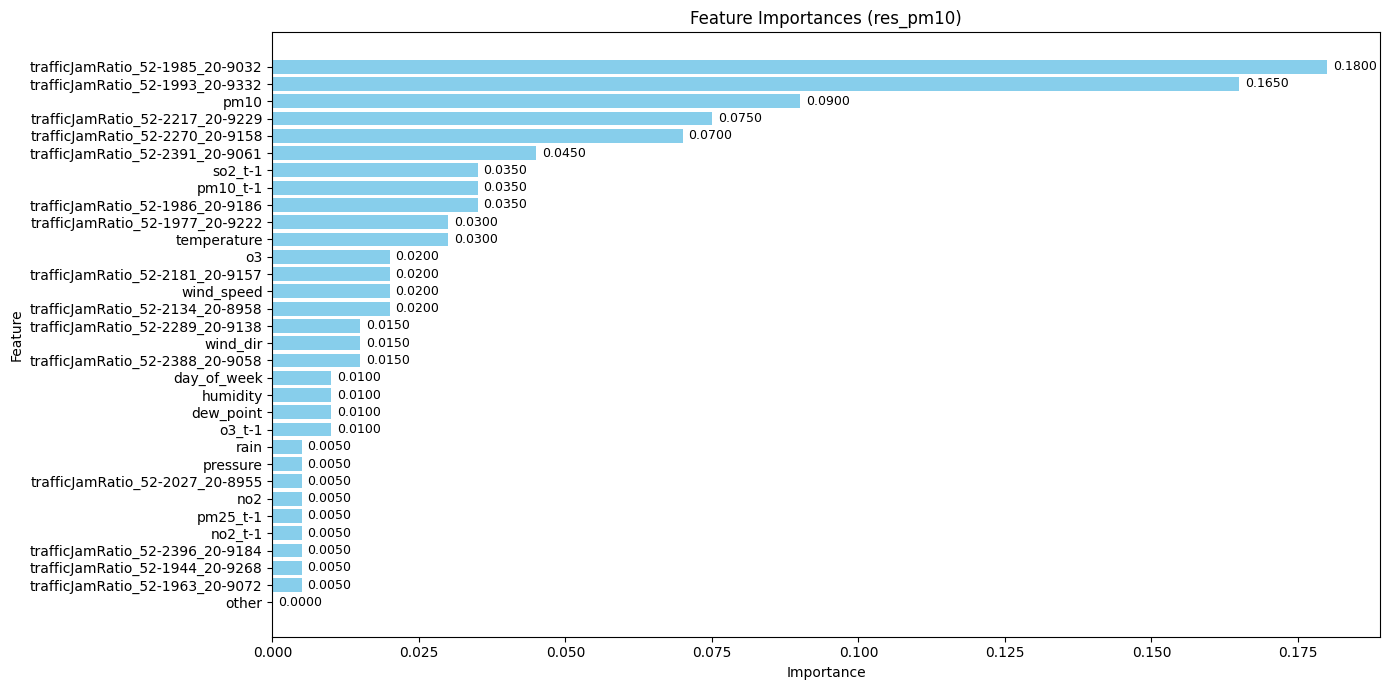

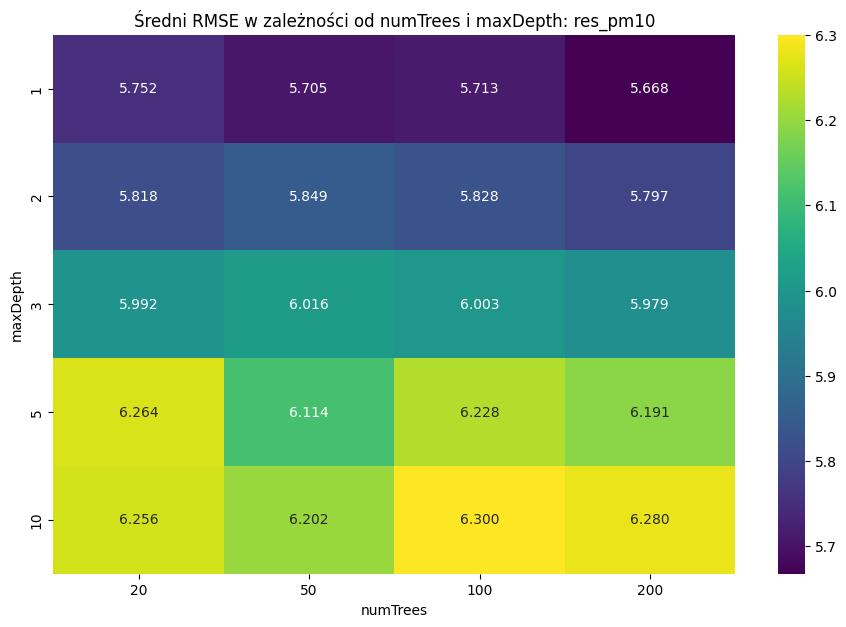

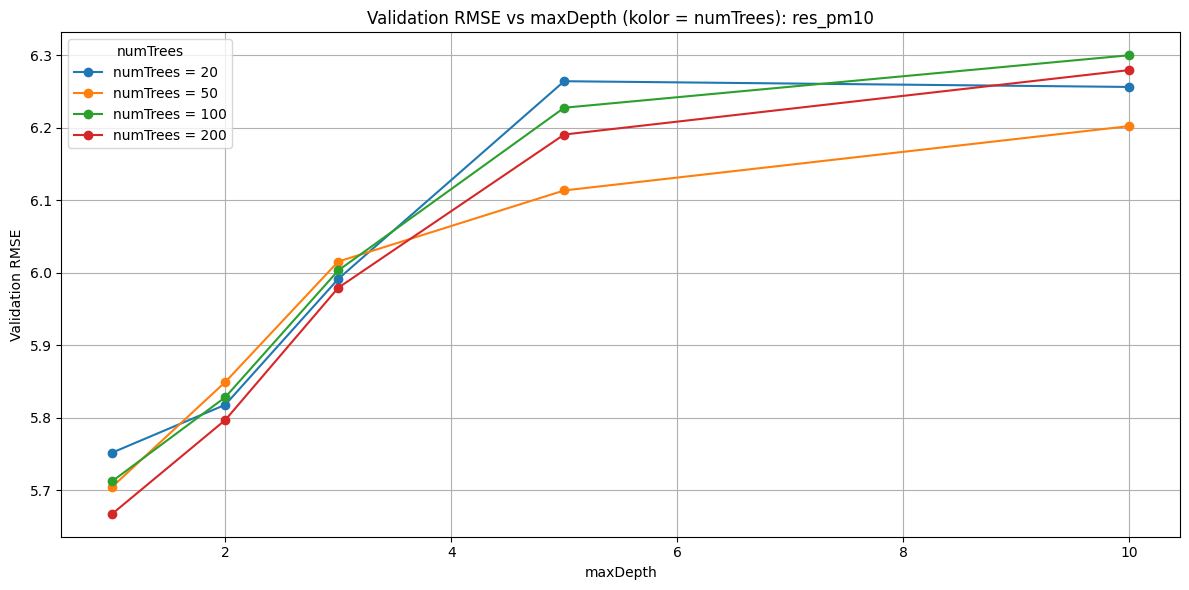

                            feature  importance
23  trafficJamRatio_52-1985_20-9032       0.180
25  trafficJamRatio_52-1993_20-9332       0.165
10                             pm10       0.090
32  trafficJamRatio_52-2217_20-9229       0.075
33  trafficJamRatio_52-2270_20-9158       0.070
40  trafficJamRatio_52-2391_20-9061       0.045
24  trafficJamRatio_52-1986_20-9186       0.035
19                          so2_t-1       0.035
15                         pm10_t-1       0.035
0                       temperature       0.030
22  trafficJamRatio_52-1977_20-9222       0.030
30  trafficJamRatio_52-2181_20-9157       0.020
13                               o3       0.020
29  trafficJamRatio_52-2134_20-8958       0.020
6                        wind_speed       0.020
7                          wind_dir       0.015
37  trafficJamRatio_52-2289_20-9138       0.015
39  trafficJamRatio_52-2388_20-9058       0.015
9                       day_of_week       0.010
18                           o3_t-1     

In [8]:
target_col = "res_pm10"

param_grid = {
    "numTrees": [20, 50, 100, 200],
    "maxDepth": [1, 2, 3, 5, 10]
}

model_save_path = "hdfs://namenode:9000/user/hadoop/modele/online_cv/online_rf_pm10"

best_params, online_model_pm10, pm10_top_features = timeseries_cv_rf(
    df_to_cv=filtered_df,
    datetime_col="datetime_utc",
    feature_cols=feature_cols_less_traffic,
    target_col=target_col,
    param_grid=param_grid,
    folds=3,
    model_save_path=model_save_path
)

print(pm10_top_features)


Testuję parametry: numTrees=20, maxDepth=1

=== Fold 1 ===
 Fold 1: RMSE=2.3116, R2=-0.2565

=== Fold 2 ===
 Fold 2: RMSE=1.8345, R2=-0.0613

=== Fold 3 ===
 Fold 3: RMSE=2.0364, R2=-0.0270
 Średni RMSE dla parametrów numTrees=20, maxDepth=1: 2.0608
 Średni R2 dla parametrów numTrees=20, maxDepth=1: -0.1149

Testuję parametry: numTrees=20, maxDepth=2

=== Fold 1 ===
 Fold 1: RMSE=2.2777, R2=-0.2199

=== Fold 2 ===
 Fold 2: RMSE=1.8395, R2=-0.0671

=== Fold 3 ===
 Fold 3: RMSE=1.9635, R2=0.0452
 Średni RMSE dla parametrów numTrees=20, maxDepth=2: 2.0269
 Średni R2 dla parametrów numTrees=20, maxDepth=2: -0.0806

Testuję parametry: numTrees=20, maxDepth=3

=== Fold 1 ===
 Fold 1: RMSE=2.2525, R2=-0.1930

=== Fold 2 ===
 Fold 2: RMSE=1.8961, R2=-0.1337

=== Fold 3 ===
 Fold 3: RMSE=2.0072, R2=0.0022
 Średni RMSE dla parametrów numTrees=20, maxDepth=3: 2.0519
 Średni R2 dla parametrów numTrees=20, maxDepth=3: -0.1082

Testuję parametry: numTrees=20, maxDepth=5

=== Fold 1 ===
 Fold 1: RMS

25/06/01 13:32:26 WARN DAGScheduler: Broadcasting large task binary with size 1063.6 KiB
25/06/01 13:32:26 WARN DAGScheduler: Broadcasting large task binary with size 1130.3 KiB


 Fold 2: RMSE=1.9357, R2=-0.1815

=== Fold 3 ===


25/06/01 13:32:29 WARN DAGScheduler: Broadcasting large task binary with size 1002.8 KiB
25/06/01 13:32:29 WARN DAGScheduler: Broadcasting large task binary with size 1233.1 KiB
25/06/01 13:32:29 WARN DAGScheduler: Broadcasting large task binary with size 1435.1 KiB
25/06/01 13:32:30 WARN DAGScheduler: Broadcasting large task binary with size 1608.3 KiB


 Fold 3: RMSE=1.9105, R2=0.0960
 Średni RMSE dla parametrów numTrees=100, maxDepth=10: 2.0184
 Średni R2 dla parametrów numTrees=100, maxDepth=10: -0.0777

Testuję parametry: numTrees=200, maxDepth=1

=== Fold 1 ===
 Fold 1: RMSE=2.2710, R2=-0.2127

=== Fold 2 ===
 Fold 2: RMSE=1.8071, R2=-0.0298

=== Fold 3 ===
 Fold 3: RMSE=2.0452, R2=-0.0360
 Średni RMSE dla parametrów numTrees=200, maxDepth=1: 2.0411
 Średni R2 dla parametrów numTrees=200, maxDepth=1: -0.0928

Testuję parametry: numTrees=200, maxDepth=2

=== Fold 1 ===
 Fold 1: RMSE=2.2662, R2=-0.2076

=== Fold 2 ===
 Fold 2: RMSE=1.8608, R2=-0.0919

=== Fold 3 ===
 Fold 3: RMSE=2.0205, R2=-0.0110
 Średni RMSE dla parametrów numTrees=200, maxDepth=2: 2.0491
 Średni R2 dla parametrów numTrees=200, maxDepth=2: -0.1035

Testuję parametry: numTrees=200, maxDepth=3

=== Fold 1 ===
 Fold 1: RMSE=2.2461, R2=-0.1863

=== Fold 2 ===
 Fold 2: RMSE=1.8691, R2=-0.1016

=== Fold 3 ===
 Fold 3: RMSE=1.9754, R2=0.0336
 Średni RMSE dla parametrów 

25/06/01 13:32:59 WARN DAGScheduler: Broadcasting large task binary with size 1003.0 KiB


 Fold 1: RMSE=2.2392, R2=-0.1790

=== Fold 2 ===


25/06/01 13:33:02 WARN DAGScheduler: Broadcasting large task binary with size 1111.4 KiB
25/06/01 13:33:02 WARN DAGScheduler: Broadcasting large task binary with size 1419.1 KiB
25/06/01 13:33:03 WARN DAGScheduler: Broadcasting large task binary with size 1707.4 KiB
25/06/01 13:33:03 WARN DAGScheduler: Broadcasting large task binary with size 1938.2 KiB
25/06/01 13:33:03 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB


 Fold 2: RMSE=1.9046, R2=-0.1439

=== Fold 3 ===


25/06/01 13:33:06 WARN DAGScheduler: Broadcasting large task binary with size 1372.5 KiB
25/06/01 13:33:07 WARN DAGScheduler: Broadcasting large task binary with size 1825.2 KiB
25/06/01 13:33:07 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/06/01 13:33:08 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
25/06/01 13:33:08 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB


 Fold 3: RMSE=1.9419, R2=0.0661
 Średni RMSE dla parametrów numTrees=200, maxDepth=10: 2.0286
 Średni R2 dla parametrów numTrees=200, maxDepth=10: -0.0856
Najlepsze parametry: {'numTrees': 100, 'maxDepth': 5} z RMSE: 2.0110605426094135
Model zapisany na HDFS pod: hdfs://namenode:9000/user/hadoop/modele/online_cv/online_rf_pm25
Test set RMSE: 2.2921
Test set R2: 0.0944


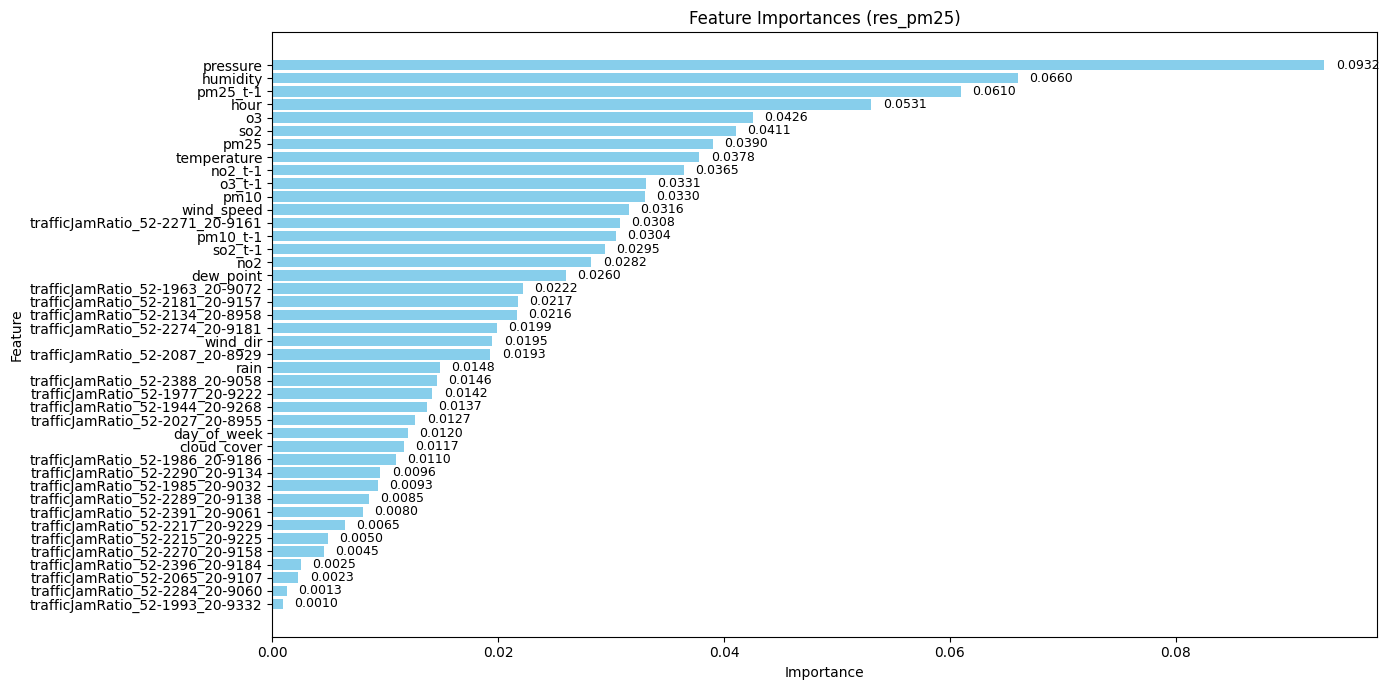

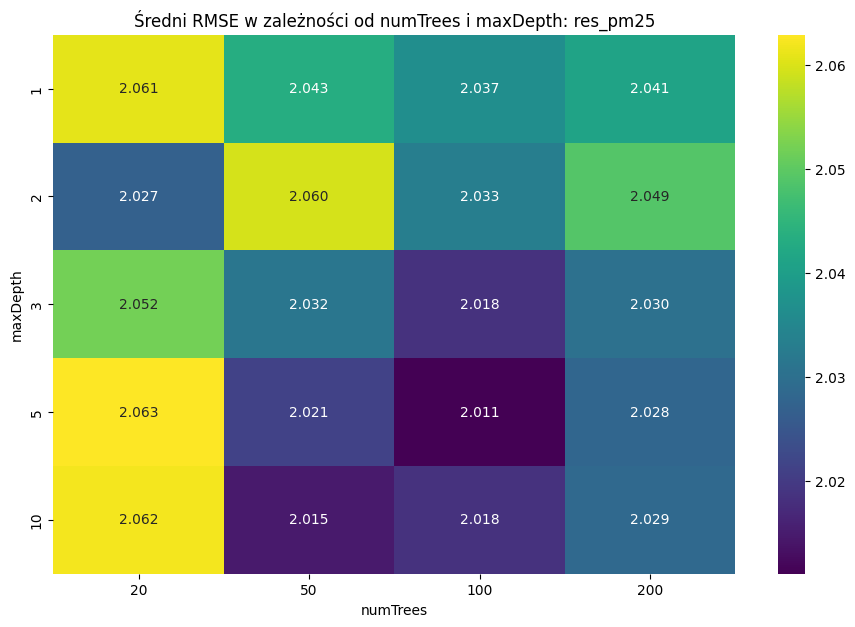

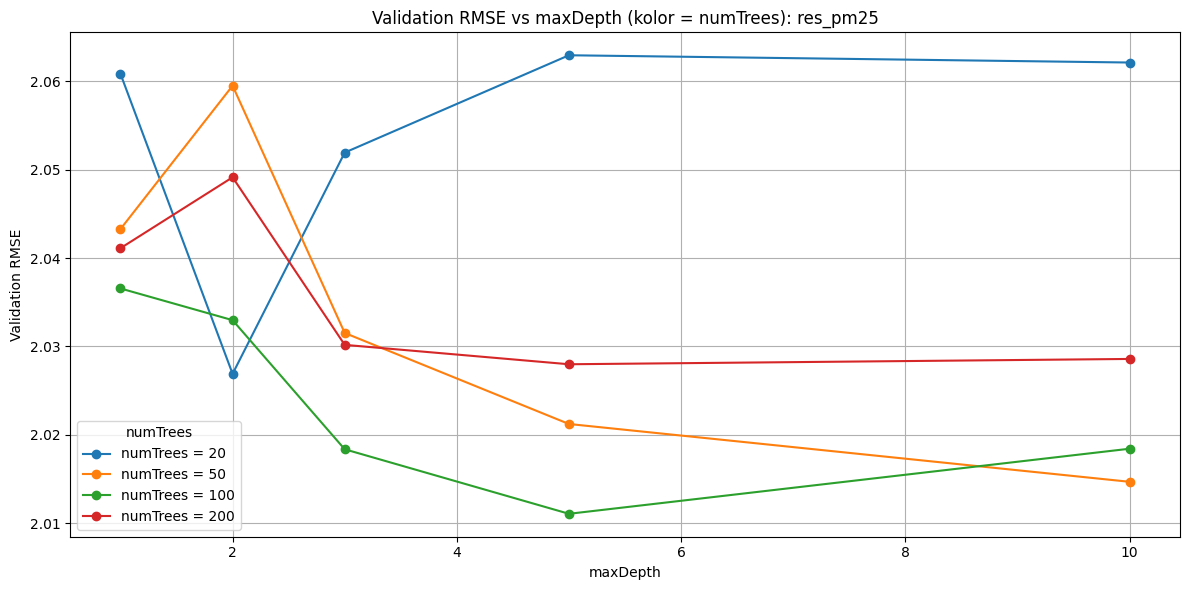

                            feature  importance
4                          pressure    0.093163
1                          humidity    0.066002
16                         pm25_t-1    0.060976
8                              hour    0.053051
13                               o3    0.042551
14                              so2    0.041081
11                             pm25    0.038990
0                       temperature    0.037811
17                          no2_t-1    0.036453
18                           o3_t-1    0.033095
10                             pm10    0.032976
6                        wind_speed    0.031605
34  trafficJamRatio_52-2271_20-9161    0.030772
15                         pm10_t-1    0.030427
19                          so2_t-1    0.029483
12                              no2    0.028246
2                         dew_point    0.025987
21  trafficJamRatio_52-1963_20-9072    0.022211
30  trafficJamRatio_52-2181_20-9157    0.021729
29  trafficJamRatio_52-2134_20-8958    0

In [9]:
target_col = "res_pm25"

param_grid = {
    "numTrees": [20, 50, 100, 200],
    "maxDepth": [1, 2, 3, 5, 10]
}

model_save_path = "hdfs://namenode:9000/user/hadoop/modele/online_cv/online_rf_pm25"

best_params, online_model_pm25, pm25_top_features = timeseries_cv_rf(
    df_to_cv=filtered_df,
    datetime_col="datetime_utc",
    feature_cols=feature_cols_less_traffic,
    target_col=target_col,
    param_grid=param_grid,
    folds=3,
    model_save_path=model_save_path
)

print(pm25_top_features)


Testuję parametry: numTrees=20, maxDepth=1

=== Fold 1 ===
 Fold 1: RMSE=4.3662, R2=-0.3627

=== Fold 2 ===
 Fold 2: RMSE=6.0755, R2=0.1114

=== Fold 3 ===
 Fold 3: RMSE=4.7269, R2=-0.2831
 Średni RMSE dla parametrów numTrees=20, maxDepth=1: 5.0562
 Średni R2 dla parametrów numTrees=20, maxDepth=1: -0.1781

Testuję parametry: numTrees=20, maxDepth=2

=== Fold 1 ===
 Fold 1: RMSE=4.3401, R2=-0.3464

=== Fold 2 ===
 Fold 2: RMSE=5.8869, R2=0.1657

=== Fold 3 ===
 Fold 3: RMSE=5.1580, R2=-0.5278
 Średni RMSE dla parametrów numTrees=20, maxDepth=2: 5.1283
 Średni R2 dla parametrów numTrees=20, maxDepth=2: -0.2362

Testuję parametry: numTrees=20, maxDepth=3

=== Fold 1 ===
 Fold 1: RMSE=4.5183, R2=-0.4593

=== Fold 2 ===
 Fold 2: RMSE=5.9016, R2=0.1615

=== Fold 3 ===
 Fold 3: RMSE=5.2410, R2=-0.5774
 Średni RMSE dla parametrów numTrees=20, maxDepth=3: 5.2203
 Średni R2 dla parametrów numTrees=20, maxDepth=3: -0.2917

Testuję parametry: numTrees=20, maxDepth=5

=== Fold 1 ===
 Fold 1: RMSE

 Fold 3: RMSE=4.5075, R2=-0.1668
 Średni RMSE dla parametrów numTrees=50, maxDepth=1: 4.9278
 Średni R2 dla parametrów numTrees=50, maxDepth=1: -0.1131

Testuję parametry: numTrees=50, maxDepth=2

=== Fold 1 ===
 Fold 1: RMSE=4.4234, R2=-0.3986

=== Fold 2 ===
 Fold 2: RMSE=5.5914, R2=0.2473

=== Fold 3 ===
 Fold 3: RMSE=4.7106, R2=-0.2743
 Średni RMSE dla parametrów numTrees=50, maxDepth=2: 4.9085
 Średni R2 dla parametrów numTrees=50, maxDepth=2: -0.1419

Testuję parametry: numTrees=50, maxDepth=3

=== Fold 1 ===
 Fold 1: RMSE=4.6594, R2=-0.5519

=== Fold 2 ===
 Fold 2: RMSE=5.6150, R2=0.2410

=== Fold 3 ===
 Fold 3: RMSE=4.7526, R2=-0.2971
 Średni RMSE dla parametrów numTrees=50, maxDepth=3: 5.0090
 Średni R2 dla parametrów numTrees=50, maxDepth=3: -0.2027

Testuję parametry: numTrees=50, maxDepth=5

=== Fold 1 ===
 Fold 1: RMSE=4.7002, R2=-0.5791

=== Fold 2 ===
 Fold 2: RMSE=5.6560, R2=0.2298

=== Fold 3 ===
 Fold 3: RMSE=4.7637, R2=-0.3032
 Średni RMSE dla parametrów numTrees=50,

25/06/01 13:34:46 WARN DAGScheduler: Broadcasting large task binary with size 1041.3 KiB
25/06/01 13:34:46 WARN DAGScheduler: Broadcasting large task binary with size 1153.7 KiB
25/06/01 13:34:47 WARN DAGScheduler: Broadcasting large task binary with size 1161.7 KiB


 Fold 2: RMSE=5.8273, R2=0.1825

=== Fold 3 ===


25/06/01 13:34:49 WARN DAGScheduler: Broadcasting large task binary with size 1021.0 KiB
25/06/01 13:34:50 WARN DAGScheduler: Broadcasting large task binary with size 1204.9 KiB
25/06/01 13:34:50 WARN DAGScheduler: Broadcasting large task binary with size 1379.2 KiB


 Fold 3: RMSE=4.9849, R2=-0.4270
 Średni RMSE dla parametrów numTrees=100, maxDepth=10: 5.1266
 Średni R2 dla parametrów numTrees=100, maxDepth=10: -0.2453

Testuję parametry: numTrees=200, maxDepth=1

=== Fold 1 ===
 Fold 1: RMSE=4.3738, R2=-0.3674

=== Fold 2 ===
 Fold 2: RMSE=5.9488, R2=0.1480

=== Fold 3 ===
 Fold 3: RMSE=4.4257, R2=-0.1248
 Średni RMSE dla parametrów numTrees=200, maxDepth=1: 4.9161
 Średni R2 dla parametrów numTrees=200, maxDepth=1: -0.1147

Testuję parametry: numTrees=200, maxDepth=2

=== Fold 1 ===
 Fold 1: RMSE=4.5314, R2=-0.4677

=== Fold 2 ===
 Fold 2: RMSE=5.6964, R2=0.2188

=== Fold 3 ===
 Fold 3: RMSE=4.5748, R2=-0.2019
 Średni RMSE dla parametrów numTrees=200, maxDepth=2: 4.9342
 Średni R2 dla parametrów numTrees=200, maxDepth=2: -0.1503

Testuję parametry: numTrees=200, maxDepth=3

=== Fold 1 ===
 Fold 1: RMSE=4.5935, R2=-0.5083

=== Fold 2 ===
 Fold 2: RMSE=5.6175, R2=0.2403

=== Fold 3 ===
 Fold 3: RMSE=4.6382, R2=-0.2354
 Średni RMSE dla parametrów n

25/06/01 13:35:21 WARN DAGScheduler: Broadcasting large task binary with size 1087.8 KiB
25/06/01 13:35:22 WARN DAGScheduler: Broadcasting large task binary with size 1084.8 KiB


 Fold 1: RMSE=4.6345, R2=-0.5353

=== Fold 2 ===


25/06/01 13:35:25 WARN DAGScheduler: Broadcasting large task binary with size 1222.6 KiB
25/06/01 13:35:25 WARN DAGScheduler: Broadcasting large task binary with size 1558.3 KiB
25/06/01 13:35:26 WARN DAGScheduler: Broadcasting large task binary with size 1876.4 KiB
25/06/01 13:35:26 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/06/01 13:35:26 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


 Fold 2: RMSE=5.6184, R2=0.2400

=== Fold 3 ===


25/06/01 13:35:30 WARN DAGScheduler: Broadcasting large task binary with size 1140.3 KiB
25/06/01 13:35:30 WARN DAGScheduler: Broadcasting large task binary with size 1520.5 KiB
25/06/01 13:35:31 WARN DAGScheduler: Broadcasting large task binary with size 1924.9 KiB
25/06/01 13:35:31 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
25/06/01 13:35:31 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB


 Fold 3: RMSE=4.5895, R2=-0.2096
 Średni RMSE dla parametrów numTrees=200, maxDepth=10: 4.9475
 Średni R2 dla parametrów numTrees=200, maxDepth=10: -0.1683
Najlepsze parametry: {'numTrees': 50, 'maxDepth': 2} z RMSE: 4.90848667557626
Model zapisany na HDFS pod: hdfs://namenode:9000/user/hadoop/modele/online_cv/online_rf_no2
Test set RMSE: 3.3514
Test set R2: 0.3581


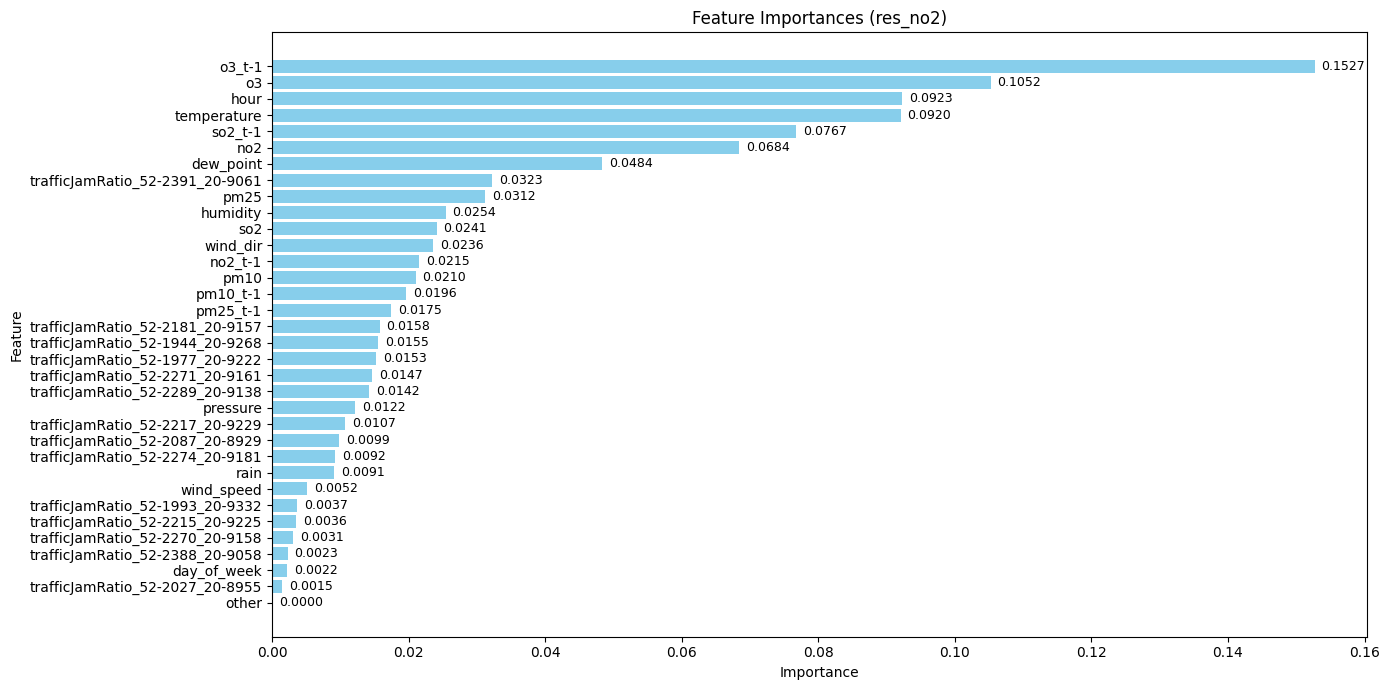

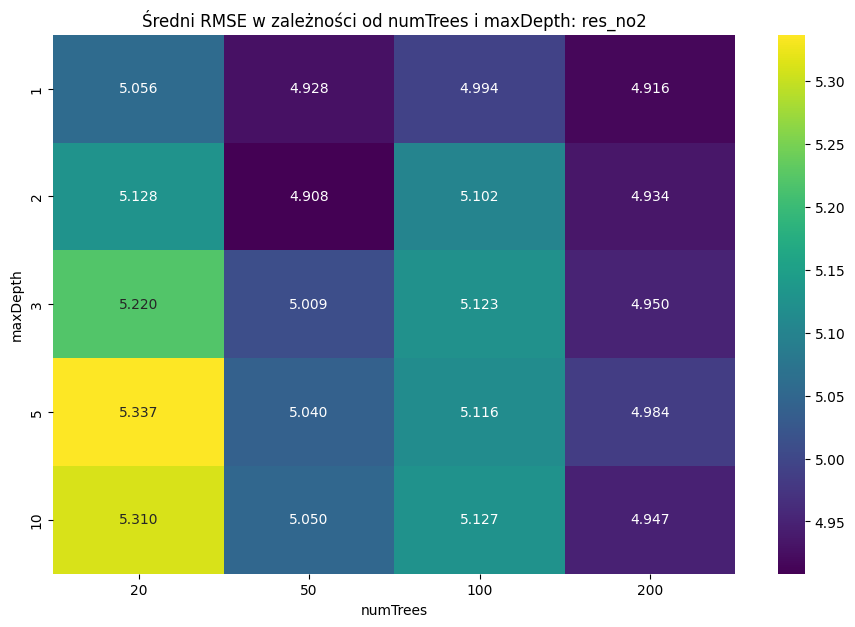

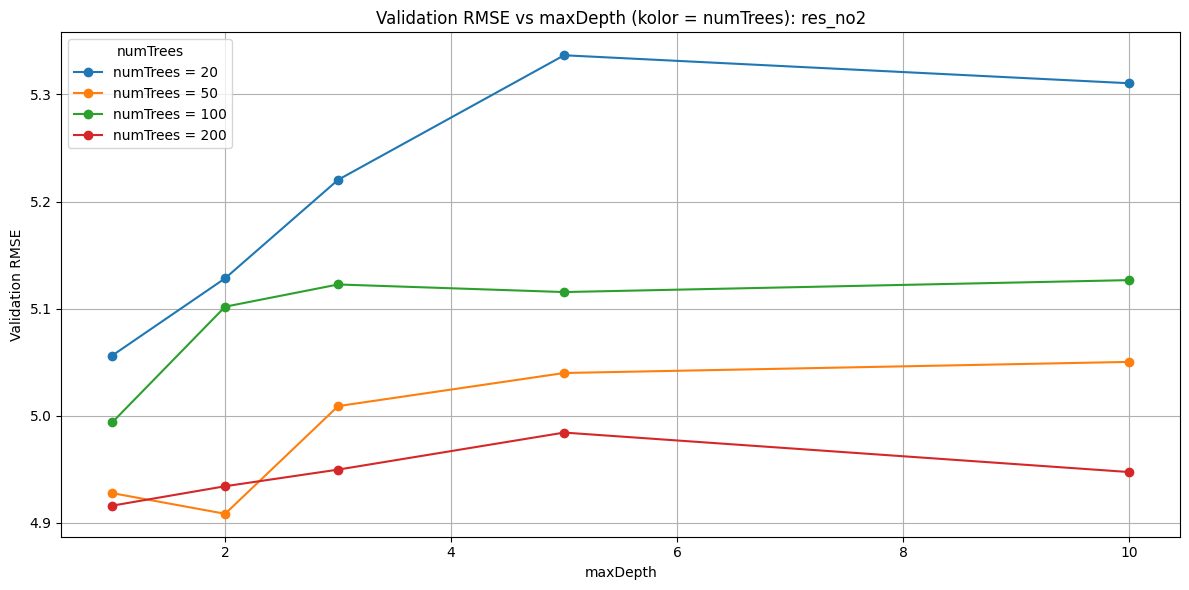

                            feature  importance
18                           o3_t-1    0.152700
13                               o3    0.105228
8                              hour    0.092266
0                       temperature    0.092041
19                          so2_t-1    0.076742
12                              no2    0.068404
2                         dew_point    0.048393
40  trafficJamRatio_52-2391_20-9061    0.032256
11                             pm25    0.031204
1                          humidity    0.025410
14                              so2    0.024103
7                          wind_dir    0.023627
17                          no2_t-1    0.021517
10                             pm10    0.021048
15                         pm10_t-1    0.019593
16                         pm25_t-1    0.017483
30  trafficJamRatio_52-2181_20-9157    0.015754
20  trafficJamRatio_52-1944_20-9268    0.015502
22  trafficJamRatio_52-1977_20-9222    0.015267
34  trafficJamRatio_52-2271_20-9161    0

In [10]:
target_col = "res_no2"

param_grid = {
    "numTrees": [20, 50, 100, 200],
    "maxDepth": [1, 2, 3, 5, 10]
}

model_save_path = "hdfs://namenode:9000/user/hadoop/modele/online_cv/online_rf_no2"

best_params, online_model_no2, no2_top_features = timeseries_cv_rf(
    df_to_cv=filtered_df,
    datetime_col="datetime_utc",
    feature_cols=feature_cols_less_traffic,
    target_col=target_col,
    param_grid=param_grid,
    folds=3,
    model_save_path=model_save_path
)

print(no2_top_features)


Testuję parametry: numTrees=20, maxDepth=1

=== Fold 1 ===
 Fold 1: RMSE=0.4974, R2=-0.2201

=== Fold 2 ===
 Fold 2: RMSE=0.4821, R2=-0.1202

=== Fold 3 ===
 Fold 3: RMSE=0.5051, R2=-0.0446
 Średni RMSE dla parametrów numTrees=20, maxDepth=1: 0.4949
 Średni R2 dla parametrów numTrees=20, maxDepth=1: -0.1283

Testuję parametry: numTrees=20, maxDepth=2

=== Fold 1 ===
 Fold 1: RMSE=0.5145, R2=-0.3050

=== Fold 2 ===
 Fold 2: RMSE=0.4896, R2=-0.1549

=== Fold 3 ===
 Fold 3: RMSE=0.5053, R2=-0.0457
 Średni RMSE dla parametrów numTrees=20, maxDepth=2: 0.5031
 Średni R2 dla parametrów numTrees=20, maxDepth=2: -0.1685

Testuję parametry: numTrees=20, maxDepth=3

=== Fold 1 ===
 Fold 1: RMSE=0.5191, R2=-0.3285

=== Fold 2 ===
 Fold 2: RMSE=0.4971, R2=-0.1907

=== Fold 3 ===
 Fold 3: RMSE=0.5228, R2=-0.1193
 Średni RMSE dla parametrów numTrees=20, maxDepth=3: 0.5130
 Średni R2 dla parametrów numTrees=20, maxDepth=3: -0.2128

Testuję parametry: numTrees=20, maxDepth=5

=== Fold 1 ===
 Fold 1: R

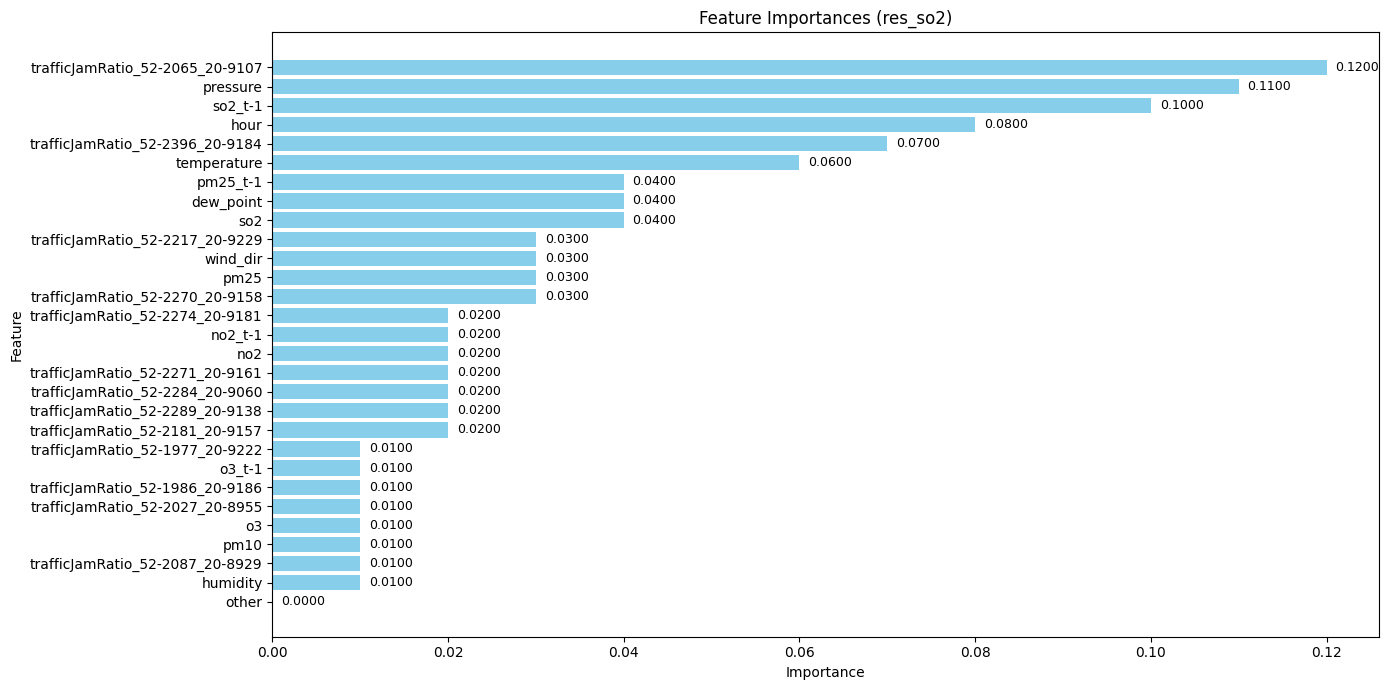

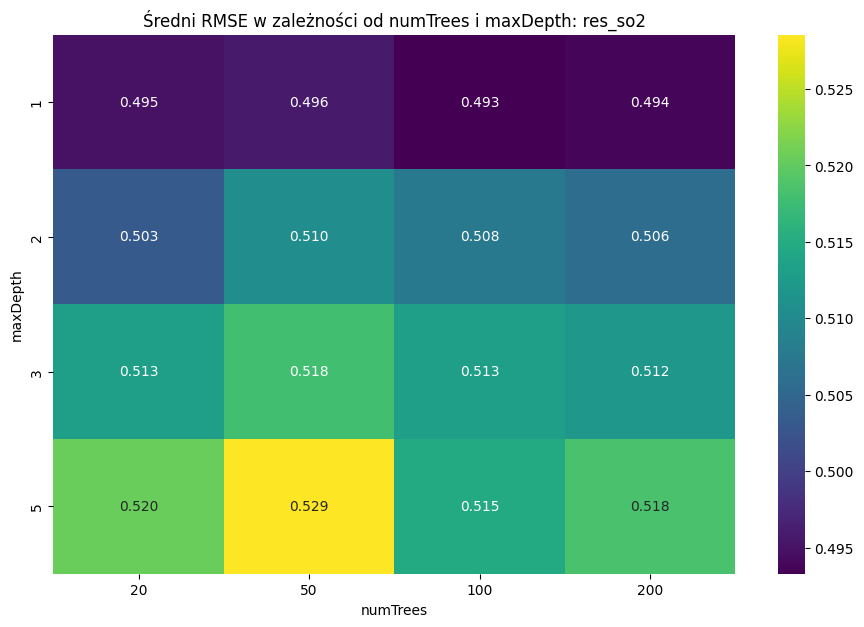

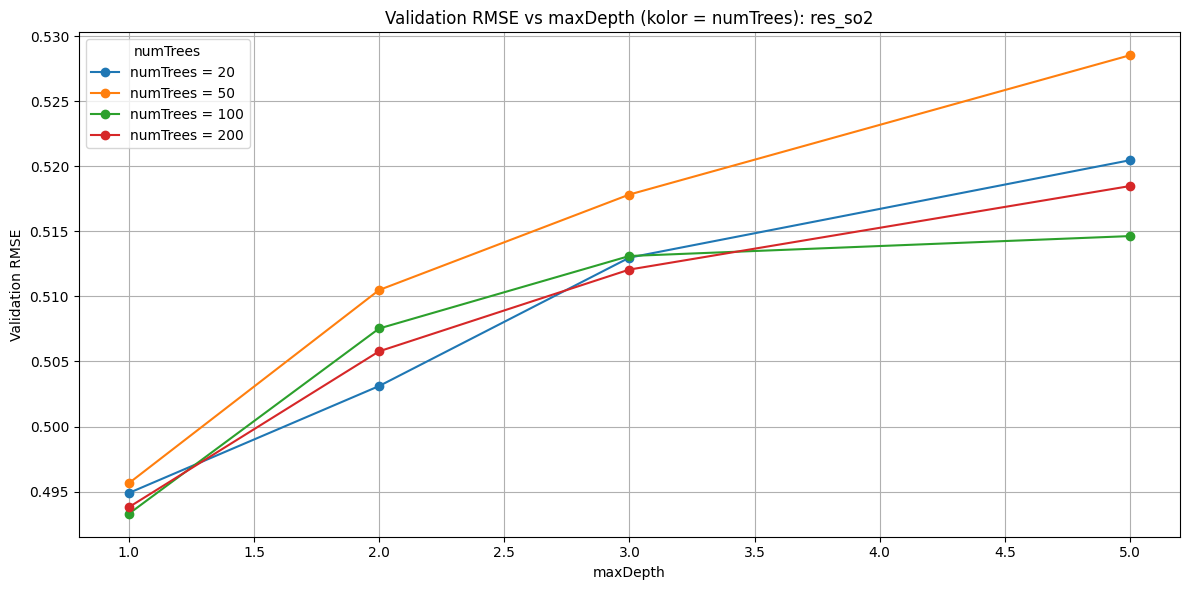

                            feature  importance
27  trafficJamRatio_52-2065_20-9107        0.12
4                          pressure        0.11
19                          so2_t-1        0.10
8                              hour        0.08
41  trafficJamRatio_52-2396_20-9184        0.07
0                       temperature        0.06
2                         dew_point        0.04
14                              so2        0.04
16                         pm25_t-1        0.04
33  trafficJamRatio_52-2270_20-9158        0.03
11                             pm25        0.03
32  trafficJamRatio_52-2217_20-9229        0.03
7                          wind_dir        0.03
30  trafficJamRatio_52-2181_20-9157        0.02
35  trafficJamRatio_52-2274_20-9181        0.02
12                              no2        0.02
34  trafficJamRatio_52-2271_20-9161        0.02
17                          no2_t-1        0.02
37  trafficJamRatio_52-2289_20-9138        0.02
36  trafficJamRatio_52-2284_20-9060     

In [11]:
target_col = "res_so2"

param_grid = {
    "numTrees": [20, 50, 100, 200],
    "maxDepth": [1, 2, 3, 5]
}

model_save_path = "hdfs://namenode:9000/user/hadoop/modele/online_cv/online_rf_so2"

best_params, online_model_so2, so2_top_features = timeseries_cv_rf(
    df_to_cv=filtered_df,
    datetime_col="datetime_utc",
    feature_cols=feature_cols_less_traffic,
    target_col=target_col,
    param_grid=param_grid,
    folds=3,
    model_save_path=model_save_path
)

print(so2_top_features)


Testuję parametry: numTrees=20, maxDepth=1

=== Fold 1 ===
 Fold 1: RMSE=5.2511, R2=-0.0277

=== Fold 2 ===
 Fold 2: RMSE=4.9519, R2=-0.2343

=== Fold 3 ===
 Fold 3: RMSE=4.1984, R2=0.0501
 Średni RMSE dla parametrów numTrees=20, maxDepth=1: 4.8004
 Średni R2 dla parametrów numTrees=20, maxDepth=1: -0.0706

Testuję parametry: numTrees=20, maxDepth=2

=== Fold 1 ===
 Fold 1: RMSE=5.5900, R2=-0.1647

=== Fold 2 ===
 Fold 2: RMSE=5.2151, R2=-0.3690

=== Fold 3 ===
 Fold 3: RMSE=4.0613, R2=0.1111
 Średni RMSE dla parametrów numTrees=20, maxDepth=2: 4.9555
 Średni R2 dla parametrów numTrees=20, maxDepth=2: -0.1409

Testuję parametry: numTrees=20, maxDepth=3

=== Fold 1 ===
 Fold 1: RMSE=5.5579, R2=-0.1514

=== Fold 2 ===
 Fold 2: RMSE=5.1718, R2=-0.3463

=== Fold 3 ===
 Fold 3: RMSE=4.0135, R2=0.1319
 Średni RMSE dla parametrów numTrees=20, maxDepth=3: 4.9144
 Średni R2 dla parametrów numTrees=20, maxDepth=3: -0.1220

Testuję parametry: numTrees=20, maxDepth=5

=== Fold 1 ===
 Fold 1: RMSE

25/06/01 13:38:49 WARN DAGScheduler: Broadcasting large task binary with size 1106.6 KiB
25/06/01 13:38:49 WARN DAGScheduler: Broadcasting large task binary with size 1177.8 KiB


 Fold 2: RMSE=4.7157, R2=-0.1193

=== Fold 3 ===


25/06/01 13:38:52 WARN DAGScheduler: Broadcasting large task binary with size 1002.7 KiB
25/06/01 13:38:52 WARN DAGScheduler: Broadcasting large task binary with size 1238.6 KiB
25/06/01 13:38:52 WARN DAGScheduler: Broadcasting large task binary with size 1447.5 KiB
25/06/01 13:38:53 WARN DAGScheduler: Broadcasting large task binary with size 1622.7 KiB


 Fold 3: RMSE=4.1126, R2=0.0885
 Średni RMSE dla parametrów numTrees=100, maxDepth=10: 4.6776
 Średni R2 dla parametrów numTrees=100, maxDepth=10: -0.0135

Testuję parametry: numTrees=200, maxDepth=1

=== Fold 1 ===
 Fold 1: RMSE=5.1934, R2=-0.0053

=== Fold 2 ===
 Fold 2: RMSE=4.6823, R2=-0.1035

=== Fold 3 ===
 Fold 3: RMSE=4.1855, R2=0.0559
 Średni RMSE dla parametrów numTrees=200, maxDepth=1: 4.6871
 Średni R2 dla parametrów numTrees=200, maxDepth=1: -0.0176

Testuję parametry: numTrees=200, maxDepth=2

=== Fold 1 ===
 Fold 1: RMSE=5.1662, R2=0.0052

=== Fold 2 ===
 Fold 2: RMSE=4.7796, R2=-0.1499

=== Fold 3 ===
 Fold 3: RMSE=4.1964, R2=0.0510
 Średni RMSE dla parametrów numTrees=200, maxDepth=2: 4.7141
 Średni R2 dla parametrów numTrees=200, maxDepth=2: -0.0312

Testuję parametry: numTrees=200, maxDepth=3

=== Fold 1 ===
 Fold 1: RMSE=5.1183, R2=0.0235

=== Fold 2 ===
 Fold 2: RMSE=4.8215, R2=-0.1701

=== Fold 3 ===
 Fold 3: RMSE=4.2678, R2=0.0184
 Średni RMSE dla parametrów numT

25/06/01 13:39:20 WARN DAGScheduler: Broadcasting large task binary with size 1047.0 KiB
25/06/01 13:39:20 WARN DAGScheduler: Broadcasting large task binary with size 1076.1 KiB


 Fold 1: RMSE=5.0737, R2=0.0405

=== Fold 2 ===


25/06/01 13:39:23 WARN DAGScheduler: Broadcasting large task binary with size 1160.9 KiB
25/06/01 13:39:23 WARN DAGScheduler: Broadcasting large task binary with size 1476.8 KiB
25/06/01 13:39:24 WARN DAGScheduler: Broadcasting large task binary with size 1791.7 KiB
25/06/01 13:39:24 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
25/06/01 13:39:24 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB


 Fold 2: RMSE=4.9428, R2=-0.2298

=== Fold 3 ===


25/06/01 13:39:27 WARN DAGScheduler: Broadcasting large task binary with size 1364.1 KiB
25/06/01 13:39:28 WARN DAGScheduler: Broadcasting large task binary with size 1794.8 KiB
25/06/01 13:39:28 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/06/01 13:39:29 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
25/06/01 13:39:29 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB


 Fold 3: RMSE=4.1749, R2=0.0607
 Średni RMSE dla parametrów numTrees=200, maxDepth=10: 4.7305
 Średni R2 dla parametrów numTrees=200, maxDepth=10: -0.0429
Najlepsze parametry: {'numTrees': 50, 'maxDepth': 5} z RMSE: 4.647970153345903
Model zapisany na HDFS pod: hdfs://namenode:9000/user/hadoop/modele/online_cv/online_rf_o3
Test set RMSE: 4.6547
Test set R2: -0.1240


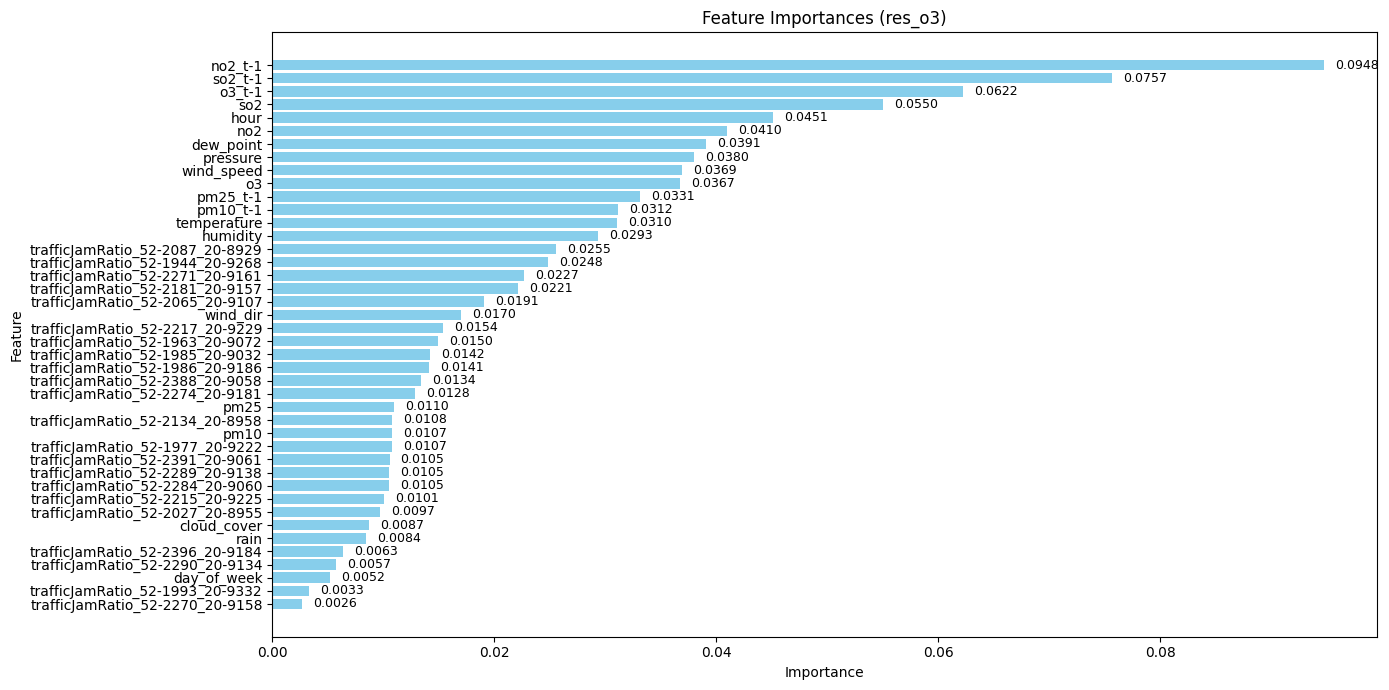

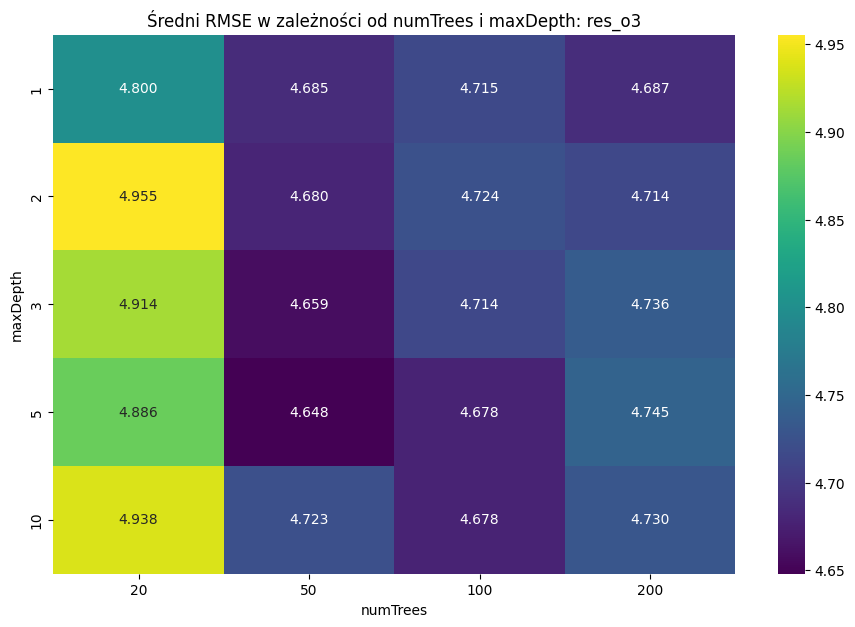

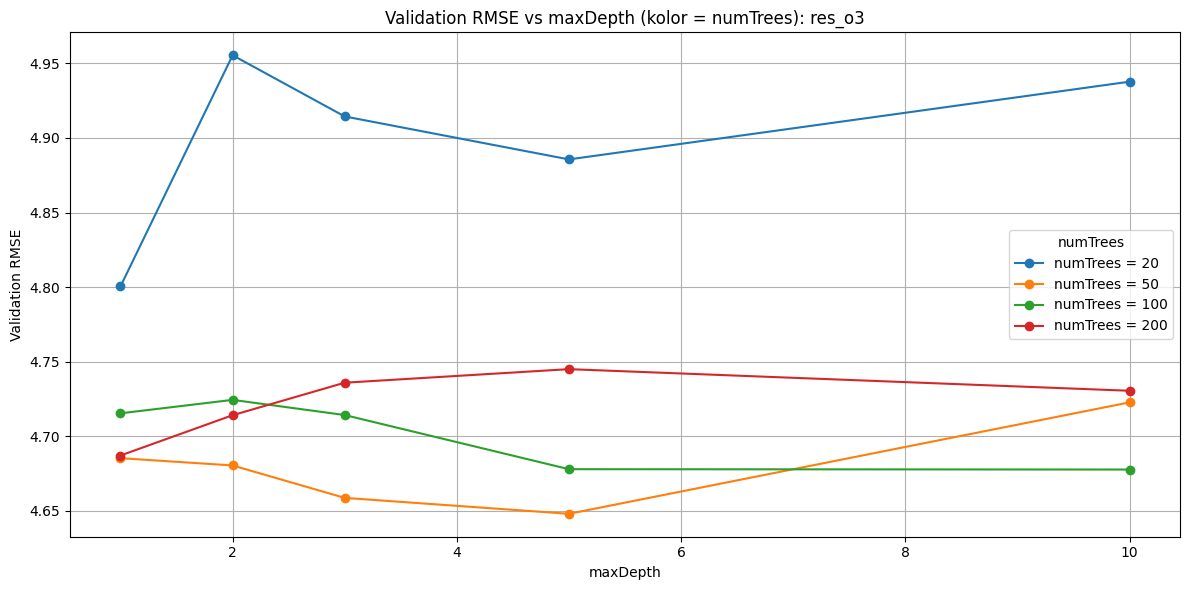

                            feature  importance
17                          no2_t-1    0.094775
19                          so2_t-1    0.075667
18                           o3_t-1    0.062221
14                              so2    0.055009
8                              hour    0.045109
12                              no2    0.040994
2                         dew_point    0.039103
4                          pressure    0.038013
6                        wind_speed    0.036934
13                               o3    0.036686
16                         pm25_t-1    0.033134
15                         pm10_t-1    0.031162
0                       temperature    0.031021
1                          humidity    0.029308
28  trafficJamRatio_52-2087_20-8929    0.025522
20  trafficJamRatio_52-1944_20-9268    0.024827
34  trafficJamRatio_52-2271_20-9161    0.022704
30  trafficJamRatio_52-2181_20-9157    0.022091
27  trafficJamRatio_52-2065_20-9107    0.019096
7                          wind_dir    0

In [12]:
target_col = "res_o3"

param_grid = {
    "numTrees": [20, 50, 100, 200],
    "maxDepth": [1, 2, 3, 5, 10]
}

model_save_path = "hdfs://namenode:9000/user/hadoop/modele/online_cv/online_rf_o3"

best_params, online_model_o3, o3_top_features = timeseries_cv_rf(
    df_to_cv=filtered_df,
    datetime_col="datetime_utc",
    feature_cols=feature_cols_less_traffic,
    target_col=target_col,
    param_grid=param_grid,
    folds=3,
    model_save_path=model_save_path
)

print(o3_top_features)